In [1]:
import numpy as np
import _pickle as cPickle
import os
import gzip
import matplotlib.pyplot as plt
import time
import random

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [3]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x): 
    return (1.0-sigmoid(x))*sigmoid(x)
    
def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return (1.0-tanh(x)**2)

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):   
    x[x<=0] = 0
    x[x>0] = 1
    return x
    
    
def softmax(x, axis=1):
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')

    def fprop(self, input):
        self.last_input = input.copy()
        return self.act(self.last_input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input) 
                       

class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

        
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        
        self.num_units = num_units
        self.activation_fun = activation_fun      
        self.input_shape = input_layer.output_size()
        self.W = np.random.normal(loc=0.0, scale=init_stddev, size=(self.input_shape[1], num_units))
        self.b = np.random.normal(loc=0.0, scale=init_stddev, size=(num_units,))     
        self.dW = None
        self.db = None
            
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        self.last_input = input.copy()
        z_current = np.dot(self.last_input, self.W) + self.b   
        
        if self.activation_fun == None:
            return z_current
        else:
            a_current = self.activation_fun.fprop(z_current)
            return a_current
       
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """   
        
        n = output_grad.shape[0]
        dz_current = output_grad
        
        if self.activation_fun == None:
            da_current = output_grad
        else:
            da_current = output_grad
            dz_current = self.activation_fun.bprop(da_current)
            
        self.dW = np.dot(self.last_input.T, dz_current)
        self.db = np.sum(dz_current, axis=0)
        da_previous = np.dot(dz_current, self.W.T)
            
        return da_previous          
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )

    def input_grad(self, Y, Y_pred):       
        return (Y_pred - Y) / Y.shape[0]
      
    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        out = (Y_pred - Y) / Y.shape[0]
        return out
        
    def loss(self, Y, Y_pred):
        eps = 1e-10 # 
        loss = np.sum(-np.log(Y_pred+eps)*Y, axis=1)
        return np.mean(loss)

        

# plotting functions

In [4]:
class Makeplot:
        
    def __init__ (self, n_epoch):
        %matplotlib notebook
        self.figure = 0
        self.axes  = 0
        self.figure, self.axes = plt.subplots(1, 1)
        self.axes.set_title('Training Progress')
        self.axes.set_xlim([0, n_epoch])
        self.axes.set_ylim([0, 1])
        self.axes.set_xlabel('epoch')
        self.axes.set_ylabel('error')
    
    def plot_update (self, training_loss, validation_loss):
        if self.axes.lines:
            self.axes.lines[0].set_ydata(training_loss)
            self.axes.lines[1].set_ydata(validation_loss)
            self.axes.set_ylim([0, max(max(training_loss), max(validation_loss))])
        else:
            self.axes.plot(training_loss, c='b', label='Training Loss')
            self.axes.plot(validation_loss, c='m', label='Validation Loss')
            self.axes.legend(loc='upper right')
        
        self.figure.canvas.draw()




In [5]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """

    def __init__(self, layers):
        self.layers = layers
        self.dWSum = [0 for _ in range(len(self.layers))]
        self.dbSum = [0 for _ in range(len(self.layers))]

    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        y_pred = X
        for layer in self.layers:
            y_pred = layer.fprop(y_pred)
        return y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        for i in reversed(range(upto, len(self.layers)-1)):
            next_grad = self.layers[i].bprop(next_grad)
        return next_grad

    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)

    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            if random.random() > 0.5:
                continue         
            x_batch = X[b*batch_size: (b+1)*batch_size]
            y_batch = Y[b*batch_size: (b+1)*batch_size]
            Y_batch_pred = self.predict(x_batch) 
            self.backpropagate(y_batch, Y_batch_pred)
            self.update_weights(learning_rate) 
        
    def gd_epoch(self, X, Y, learning_rate):
        prediction = self.predict(X)
        self.backpropagate(Y, prediction)
        self.update_weights(learning_rate)
        
                       
    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, 
              batch_size=64, descent_type="sgd", y_one_hot=True):
        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        self.plot = Makeplot(max_epochs)
        if y_one_hot:
            Y_train = one_hot(Y)
            Y_valOneHot = one_hot(Y_valid)
        else:
            Y_train = Y
            Y_valOneHot = Y_valid
        print("... starting training")
        
        train_loss = np.empty((max_epochs+1,))
        train_loss[:] = np.nan   
        train_error = np.empty((max_epochs+1,))
        train_error[:] = np.nan
        validation_loss = np.empty((max_epochs+1,))
        validation_loss[:] = np.nan       
        validation_error = np.empty((max_epochs+1,))
        validation_error[:] = np.nan
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            print("Proceeding epoch: " + str(e) + "...")
            train_loss[e] = self._loss(X, Y_train)
            train_error[e] = self.classification_error(X, Y)
            validation_loss[e] = self._loss(X_valid, Y_valOneHot)
            validation_error[e] = self.classification_error(X_valid, Y_valid)
            
            print('epoch {:.4f}, loss {:.4f}, train error {:.4f}, validation error {:.4f}'.format(e, train_loss[e], train_error[e], validation_error[e]))
            self.plot.plot_update(train_loss, validation_loss)
            
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    param_shape = param.shape
                       
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        param[:] = np.reshape(param_new, param_shape)
                        return self._loss(X, Y)
                    
                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        param[:] = np.reshape(param_new, param_shape)
                        Y_pred = self.predict(X)
                        self.backpropagate(Y, Y_pred, upto=l)
                        return np.ravel(self.layers[l].grad_params()[p])


                    param_init = np.ravel(np.copy(param))
                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, 
                          grad_given_params, param_init) 
                    print('diff scipy {:.2e}'.format(err))
                    assert(err < epsilon)

                    param[:] = np.reshape(param_init, param_shape)
                    
    def ada_update_sum(self, index):
        self.dWSum[index] += self.layers[index].dW**2
        self.dbSum[index] += self.layers[index].db**2
        
    
    def ada_get_learning_rate_w(self, learning_rate, index, epsilon=1e-8):
        return learning_rate / np.sqrt(self.dWSum[index]+epsilon)
    

    def ada_get_learning_rate_b(self, learning_rate, index, epsilon=1e-8):
        return learning_rate / np.sqrt(self.dbSum[index]+epsilon)
    
    def update_weights(self, learning_rate):     
        for l in self.layers:
            if isinstance(l, Parameterized):
                l.W -= l.dW * learning_rate
                l.b -= l.db * learning_rate


# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [6]:
#input_shape = (5, 10)
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [7]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [8]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff scipy 0.00e+00
diff scipy 0.00e+00
checking gradient for layer 2
diff scipy 0.00e+00
diff scipy 0.00e+00
checking gradient for layer 3
diff scipy 0.00e+00
diff scipy 0.00e+00


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [9]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [10]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [11]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)


<IPython.core.display.Javascript object>


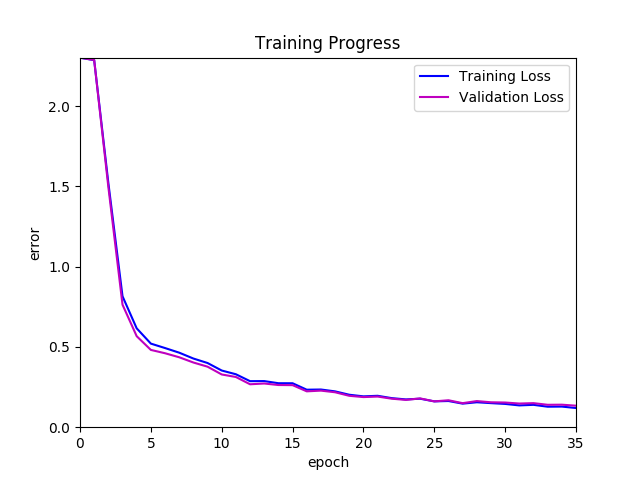

... starting training
Proceeding epoch: 0...
epoch 0.0000, loss 2.3010, train error 0.8864, validation error 0.8936
Proceeding epoch: 1...
epoch 1.0000, loss 2.2858, train error 0.8400, validation error 0.8511
Proceeding epoch: 2...
epoch 2.0000, loss 1.5216, train error 0.6036, validation error 0.5953
Proceeding epoch: 3...
epoch 3.0000, loss 0.8156, train error 0.2794, validation error 0.2546
Proceeding epoch: 4...
epoch 4.0000, loss 0.6156, train error 0.1882, validation error 0.1708
Proceeding epoch: 5...
epoch 5.0000, loss 0.5205, train error 0.1556, validation error 0.1484
Proceeding epoch: 6...
epoch 6.0000, loss 0.4929, train error 0.1462, validation error 0.1388
Proceeding epoch: 7...
epoch 7.0000, loss 0.4641, train error 0.1382, validation error 0.1301
Proceeding epoch: 8...
epoch 8.0000, loss 0.4276, train error 0.1273, validation error 0.1224
Proceeding epoch: 9...
epoch 9.0000, loss 0.3997, train error 0.1213, validation error 0.1160
Proceeding epoch: 10...
epoch 10.0000,

In [12]:
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=250,
                init_stddev=0.01,
                activation_fun=Activation('sigmoid')
))

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=50,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))



layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.1, 
         max_epochs=35, batch_size=64, y_one_hot=True, descent_type="sgd")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))






